***First, let's get to know the dataset.***

The Hitters dataset contains certain statistics and salaries of Major League Baseball players from 1986 to 1987.
A data frame with 322 observations of major league players on the following 20 variables.

AtBat: Number of times at bat in 1986 (vuruş sayısı)

Hits: Number of hits in 1986 (isabet sayısı)

HmRun: Number of home runs in 1986 (sayı vuruşu)

Runs: Number of runs in 1986 (beyzbolda takım arkadaşlarına koşu hakkı kazandıran vuruş sayısı)

RBI: Number of runs batted in in 1986 (beyzbolda vuruşçunun performansını gösteren parametre)

Walks: Number of walks in 1986 (vurucu,vuruş yapmadan birinci kaleye yürümek)

Years: Number of years in the major leagues

CAtBat: Number of times at bat during his career

CHits: Number of hits during his career

CHmRun: Number of home runs during his career

CRuns: Number of runs during his career

CRBI: Number of runs batted in during his career

CWalks: Number of walks during his career

League: A factor with levels A and N indicating player’s league at the end of 1986

Division: A factor with levels E and W indicating player’s division at the end of 1986

PutOuts: Number of put outs in 1986

Assists: Number of assists in 1986

Errors: Number of errors in 1986

Salary: 1987 annual salary on opening day in thousands of dollars

NewLeague: A factor with levels A and N indicating player’s league at the beginning of 1987

***Required Libraries and Functions***  

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import Ridge,Lasso,ElasticNet
from catboost import CatBoostRegressor
from lightgbm import LGBMRegressor
from xgboost import XGBRegressor
from sklearn.svm import SVR
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn import neighbors
import missingno as msno
import warnings
from pandas.core.common import SettingWithCopyWarning
from sklearn.exceptions import ConvergenceWarning

***Dataset***

In [2]:
df = pd.read_csv("Hitters.csv")
df.head()

,AtBat,Hits,HmRun,Runs,RBI,Walks,Years,CAtBat,CHits,CHmRun,CRuns,CRBI,CWalks,League,Division,PutOuts,Assists,Errors,Salary,NewLeague
0,293,66,1,30,29,14,1,293,66,1,30,29,14,A,E,446,33,20,NaN,A
1,315,81,7,24,38,39,14,3449,835,69,321,414,375,N,W,632,43,10,475.0,N
2,479,130,18,66,72,76,3,1624,457,63,224,266,263,A,W,880,82,14,480.0,A
3,496,141,20,65,78,37,11,5628,1575,225,828,838,354,N,E,200,11,3,500.0,N
4,321,87,10,39,42,30,2,396,101,12,48,46,33,N,E,805,40,4,91.5,N


***Exploring Data Analysis(Keşifsel Veri Analizi)***

Exploratory data analysis aims to reveal basic statistics and structures that are invisible to the naked eye by employing multivariate statistical analyses and data visualization techniques.(Keşifçi veri analizinde çok değişkenli istatistiksel analizler ve veri görselleştirme yaklaşımları uygulanarak temel istatistikler ve göz ile yakalanamayacak yapıların ortaya çıkarılması amaçlanır.)


Let's have a look at some dataset details.

In [3]:
def check_df(dataframe,head=5):
    print("####Shape####")
    print(dataframe.shape)
    print("\n####Types####\n")
    print(dataframe.dtypes)
    print("\n####Head####\n")
    print(dataframe.head(head))
    print("\n####Tail####\n")
    print(dataframe.tail(head))
    print("\n####NA####\n")
    print(dataframe.isnull().sum())
    print("\n####Quantiles####")
    print(dataframe.describe([0,0.50,0.99,1]).T)

In [4]:
check_df(df)

####Shape####
(322, 20)

####Types####

AtBat          int64
Hits           int64
HmRun          int64
Runs           int64
RBI            int64
Walks          int64
Years          int64
CAtBat         int64
CHits          int64
CHmRun         int64
CRuns          int64
CRBI           int64
CWalks         int64
League        object
Division      object
PutOuts        int64
Assists        int64
Errors         int64
Salary       float64
NewLeague     object
dtype: object

####Head####

   AtBat  Hits  HmRun  Runs  RBI  Walks  Years  CAtBat  CHits  CHmRun  CRuns  \
0    293    66      1    30   29     14      1     293     66       1     30   
1    315    81      7    24   38     39     14    3449    835      69    321   
2    479   130     18    66   72     76      3    1624    457      63    224   
3    496   141     20    65   78     37     11    5628   1575     225    828   
4    321    87     10    39   42     30      2     396    101      12     48   

   CRBI  CWalks League Divisio

In [5]:
def grab_col_names(dataframe,cat_th=10,car_th=20):
    """
       It identifies the variables in the data set that are categorical, numerical, and categorical but cardinal.
       Parameters
       ----------
       dataframe:dataframe
           The names of the variables are taken from the dataframe.
       cat_th:int,float
           The class threshold is for numeric but categorical variables.
       car_th:int,float
          The class threshold is for categorical but cardinal variables.
       Returns
       -------
       cat_cols:list
           Categorical variable list.
       num_cols:list
           Numeric variable list.
       cat_but_car:list
           Cardinal variable list in categorical view.
       Notes
       -----
       cat_cols = num_cols + cat_but_car = number of variables in total
       num_but_cat is contained within cat_cols.
    """
    # Categorical Variables:cat_cols and cat_but_car
    cat_cols = [col for col in dataframe.columns if dataframe[col].dtypes == "O"]
    num_but_cat = [col for col in dataframe.columns if dataframe[col].nunique() < cat_th and
                   dataframe[col].dtypes != "O"]
    cat_but_car = [col for col in dataframe.columns if dataframe[col].nunique() > car_th and
                   dataframe[col].dtypes == "O"]
    cat_cols = cat_cols + num_but_cat
    cat_cols = [col for col in cat_cols if col not in cat_but_car]

    # Numeric Variables:num_cols
    num_cols = [col for col in dataframe.columns if dataframe[col].dtypes != "O"]
    num_cols = [col for col in num_cols if col not in num_but_cat]

    print(f"Observations: {dataframe.shape[0]}")
    print(f"Variables: {dataframe.shape[1]}")
    print(f'cat_cols: {len(cat_cols)}')
    print(f'num_cols: {len(num_cols)}')
    print(f'cat_but_car: {len(cat_but_car)}')
    print(f'num_but_cat: {len(num_but_cat)}')
    return cat_cols, num_cols, cat_but_car

In [6]:
cat_cols,num_cols,cat_but_car = grab_col_names(df)

Observations: 322
Variables: 20
cat_cols: 3
num_cols: 17
cat_but_car: 0
num_but_cat: 0


***Let's analyze the numerical variables***

In [7]:
def num_summary(dataframe,numerical_col,plot = False):
    quantiles = [0.05,0.10,0.20,0.30,0.40,0.50,0.60,0.70,0.80,0.90,0.95,0.99]
    print(dataframe[numerical_col].describe(quantiles).T)
    
    if plot:
        dataframe[numerical_col].hist()
        plt.xlabel(numerical_col)
        plt.title(numerical_col)
        plt.show(block=True)
        print("***********************************")

count    322.000000
mean     380.928571
std      153.404981
min       16.000000
5%       161.000000
10%      194.100000
20%      221.800000
30%      281.300000
40%      321.800000
50%      379.500000
60%      430.200000
70%      490.000000
80%      535.600000
90%      584.900000
95%      609.900000
99%      658.590000
max      687.000000
Name: AtBat, dtype: float64


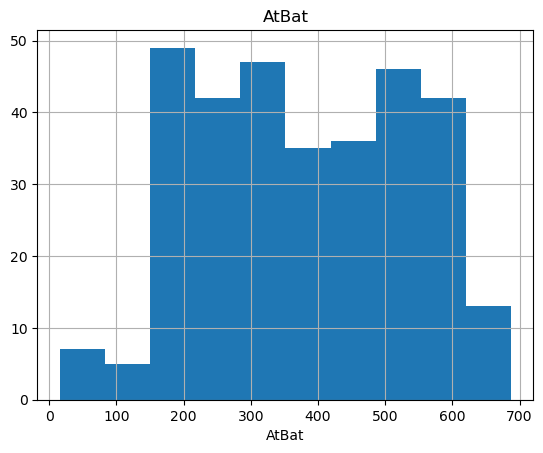

***********************************
count    322.000000
mean     101.024845
std       46.454741
min        1.000000
5%        39.000000
10%       45.100000
20%       57.000000
30%       70.000000
40%       82.000000
50%       96.000000
60%      113.000000
70%      128.700000
80%      144.000000
90%      163.000000
95%      174.000000
99%      210.790000
max      238.000000
Name: Hits, dtype: float64


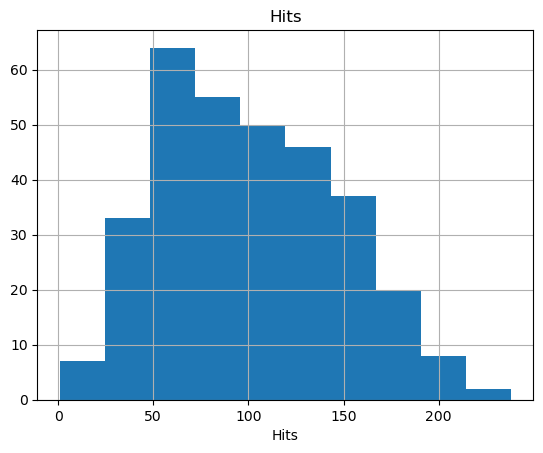

***********************************
count    322.000000
mean      10.770186
std        8.709037
min        0.000000
5%         0.000000
10%        1.000000
20%        3.000000
30%        5.000000
40%        6.000000
50%        8.000000
60%       10.600000
70%       14.000000
80%       18.000000
90%       24.000000
95%       28.950000
99%       33.000000
max       40.000000
Name: HmRun, dtype: float64


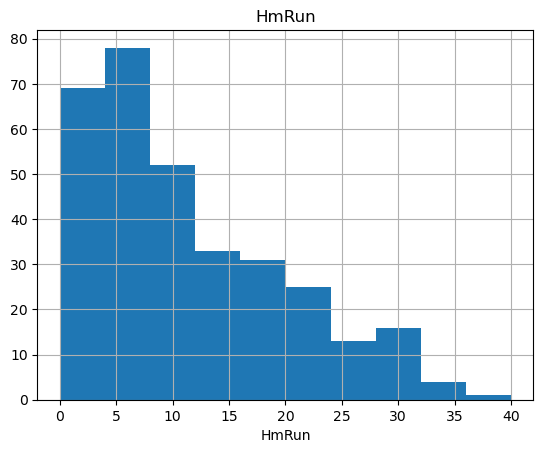

***********************************
count    322.000000
mean      50.909938
std       26.024095
min        0.000000
5%        17.000000
10%       20.100000
20%       27.000000
30%       33.000000
40%       41.000000
50%       48.000000
60%       55.600000
70%       66.000000
80%       75.800000
90%       89.000000
95%       94.000000
99%      107.790000
max      130.000000
Name: Runs, dtype: float64


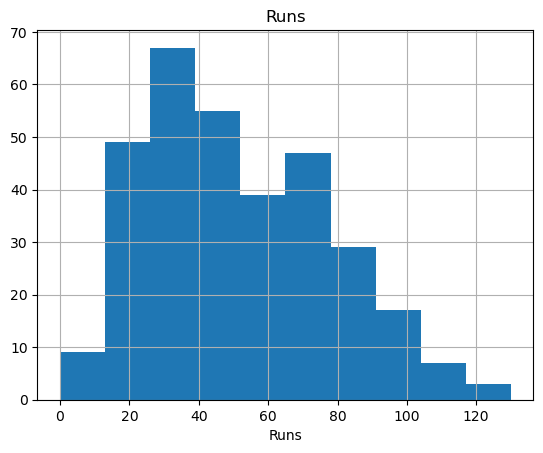

***********************************
count    322.000000
mean      48.027950
std       26.166895
min        0.000000
5%        14.000000
10%       19.000000
20%       26.000000
30%       30.000000
40%       36.400000
50%       44.000000
60%       49.000000
70%       58.000000
80%       73.000000
90%       86.000000
95%       96.000000
99%      112.370000
max      121.000000
Name: RBI, dtype: float64


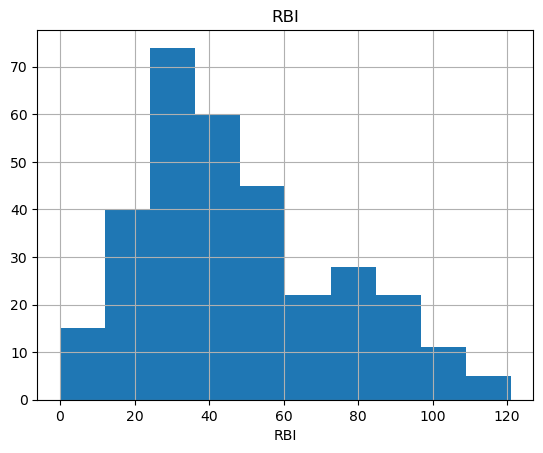

***********************************
count    322.000000
mean      38.742236
std       21.639327
min        0.000000
5%        11.050000
10%       15.000000
20%       20.000000
30%       24.000000
40%       30.000000
50%       35.000000
60%       40.000000
70%       48.700000
80%       59.000000
90%       69.900000
95%       78.000000
99%       93.580000
max      105.000000
Name: Walks, dtype: float64


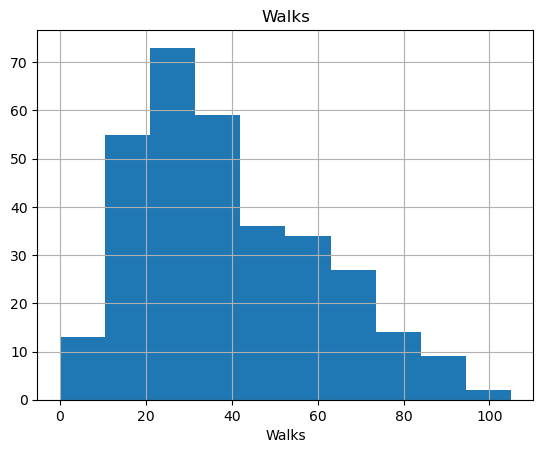

***********************************
count    322.000000
mean       7.444099
std        4.926087
min        1.000000
5%         1.000000
10%        2.000000
20%        3.000000
30%        4.000000
40%        5.000000
50%        6.000000
60%        7.600000
70%       10.000000
80%       12.000000
90%       15.000000
95%       17.000000
99%       19.790000
max       24.000000
Name: Years, dtype: float64


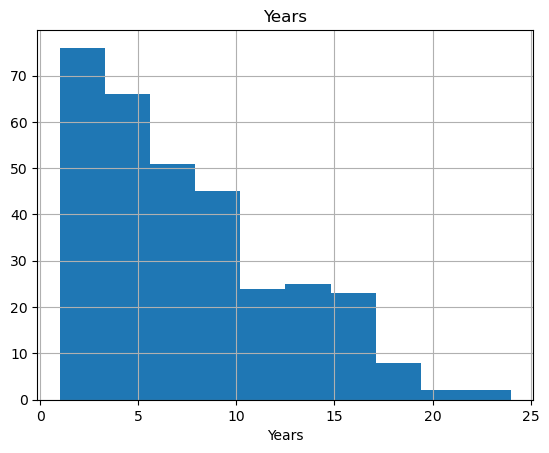

***********************************
count      322.00000
mean      2648.68323
std       2324.20587
min         19.00000
5%         216.50000
10%        342.20000
20%        667.60000
30%        963.40000
40%       1402.20000
50%       1928.00000
60%       2654.00000
70%       3365.00000
80%       4483.00000
90%       6123.40000
95%       7125.60000
99%       8749.97000
max      14053.00000
Name: CAtBat, dtype: float64


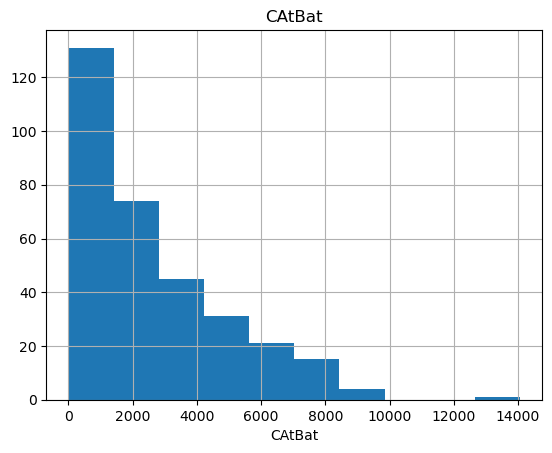

***********************************
count     322.000000
mean      717.571429
std       654.472627
min         4.000000
5%         54.000000
10%        86.000000
20%       164.600000
30%       238.000000
40%       355.800000
50%       508.000000
60%       708.200000
70%       911.100000
80%      1229.200000
90%      1659.600000
95%      2017.150000
99%      2500.340000
max      4256.000000
Name: CHits, dtype: float64


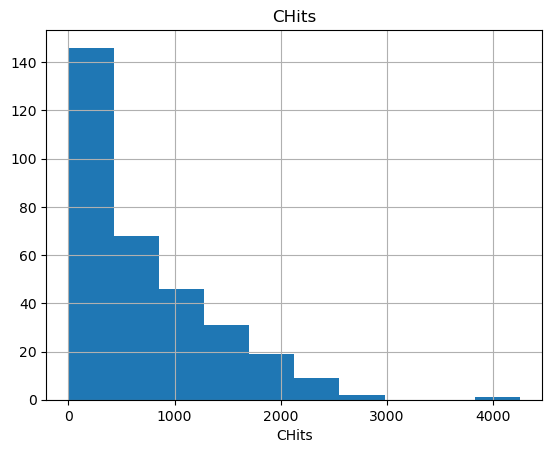

***********************************
count    322.000000
mean      69.490683
std       86.266061
min        0.000000
5%         2.000000
10%        4.000000
20%       10.200000
30%       16.300000
40%       27.400000
50%       37.500000
60%       51.200000
70%       72.400000
80%      103.800000
90%      194.900000
95%      265.650000
99%      373.120000
max      548.000000
Name: CHmRun, dtype: float64


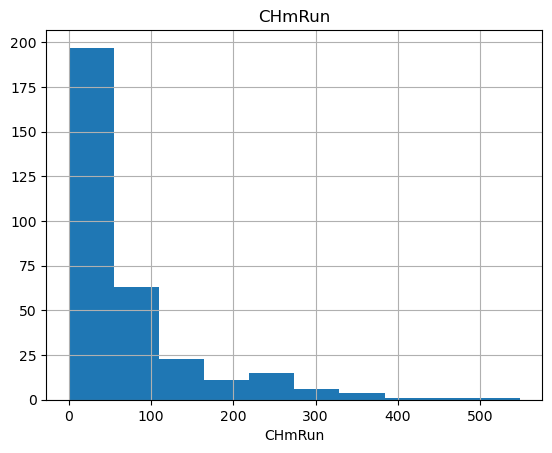

***********************************
count     322.000000
mean      358.795031
std       334.105886
min         1.000000
5%         27.000000
10%        38.100000
20%        80.400000
30%       117.300000
40%       181.000000
50%       247.000000
60%       333.000000
70%       443.400000
80%       627.200000
90%       895.700000
95%      1032.300000
99%      1174.370000
max      2165.000000
Name: CRuns, dtype: float64


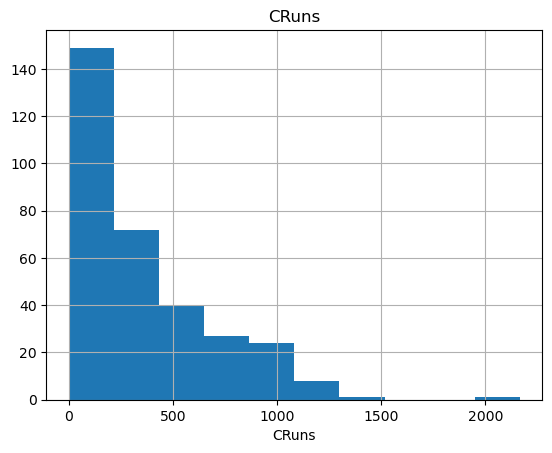

***********************************
count     322.000000
mean      330.118012
std       333.219617
min         0.000000
5%         22.050000
10%        34.100000
20%        70.200000
30%       106.300000
40%       149.000000
50%       220.500000
60%       303.600000
70%       379.100000
80%       496.200000
90%       861.600000
95%      1071.750000
99%      1310.850000
max      1659.000000
Name: CRBI, dtype: float64


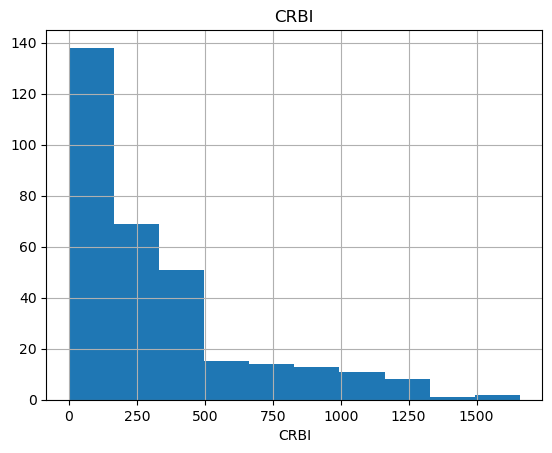

***********************************
count     322.000000
mean      260.239130
std       267.058085
min         0.000000
5%         15.050000
10%        30.100000
20%        55.000000
30%        82.000000
40%       117.400000
50%       170.500000
60%       226.600000
70%       300.700000
80%       421.000000
90%       643.900000
95%       817.600000
99%      1139.140000
max      1566.000000
Name: CWalks, dtype: float64


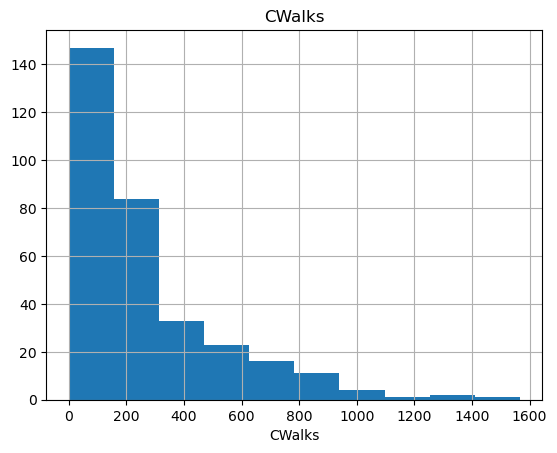

***********************************
count     322.000000
mean      288.937888
std       280.704614
min         0.000000
5%         33.200000
10%        62.200000
20%        99.600000
30%       132.000000
40%       167.000000
50%       212.000000
60%       257.400000
70%       303.000000
80%       365.800000
90%       685.600000
95%       910.650000
99%      1301.190000
max      1378.000000
Name: PutOuts, dtype: float64


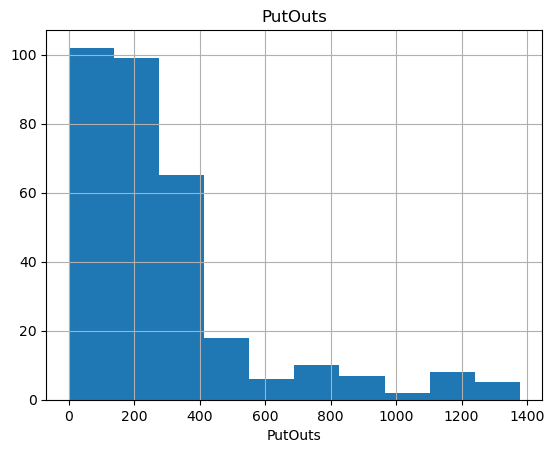

***********************************
count    322.000000
mean     106.913043
std      136.854876
min        0.000000
5%         0.000000
10%        2.000000
20%        5.200000
30%        9.000000
40%       15.400000
50%       39.500000
60%       76.800000
70%      134.800000
80%      210.800000
90%      353.300000
95%      431.450000
99%      478.160000
max      492.000000
Name: Assists, dtype: float64


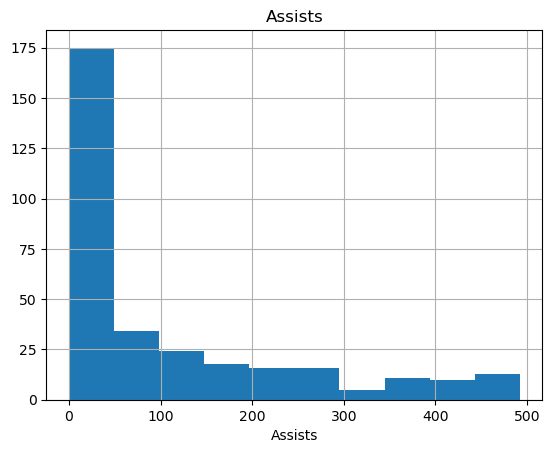

***********************************
count    322.000000
mean       8.040373
std        6.368359
min        0.000000
5%         0.000000
10%        1.000000
20%        3.000000
30%        4.000000
40%        5.000000
50%        6.000000
60%        8.000000
70%       10.000000
80%       13.000000
90%       17.000000
95%       20.000000
99%       25.790000
max       32.000000
Name: Errors, dtype: float64


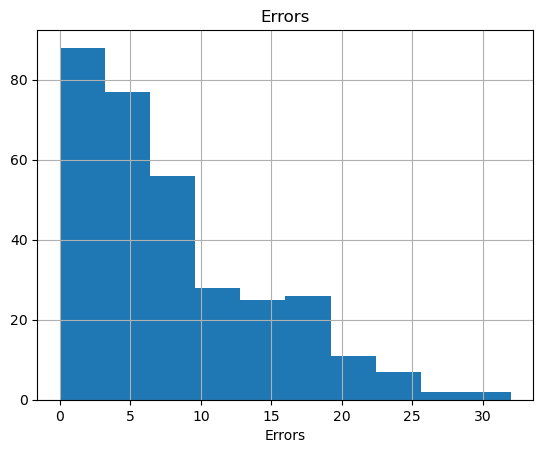

***********************************
count     263.000000
mean      535.925882
std       451.118681
min        67.500000
5%         86.600000
10%       100.000000
20%       155.000000
30%       221.000000
40%       300.000000
50%       425.000000
60%       538.000000
70%       700.000000
80%       809.000000
90%      1048.666600
95%      1346.000000
99%      2032.886540
max      2460.000000
Name: Salary, dtype: float64


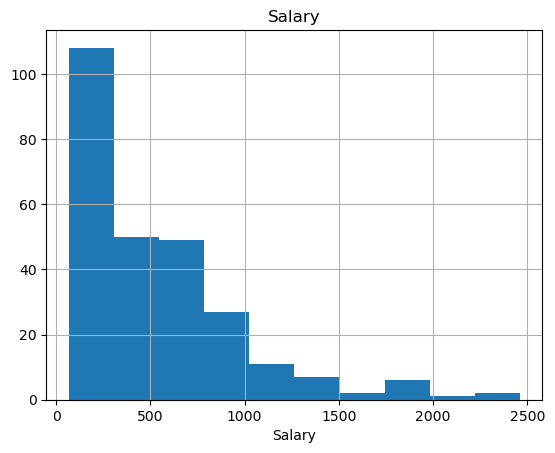

***********************************


In [8]:
for col in num_cols:
    num_summary(df,col,plot=True)

***Let's analyze the categorical variables***

In [9]:
for col in df.columns:
    if df[col].dtypes == "bool":
        df[col]=df[col].astype(int)
cat_cols,num_cols,cat_but_car = grab_col_names(df)

Observations: 322
Variables: 20
cat_cols: 3
num_cols: 17
cat_but_car: 0
num_but_cat: 0


In [10]:
def cat_summary(dataframe,col_name,plot=False):
    print(pd.DataFrame({col_name:dataframe[col_name].value_counts(),
                       "Ratio":100*dataframe[col_name].value_counts()/len(dataframe)}))
    if plot:
        sns.countplot(x=dataframe[col_name],data=dataframe)
        plt.show()
        print(f"******************************\n")

   League      Ratio
A     175  54.347826
N     147  45.652174


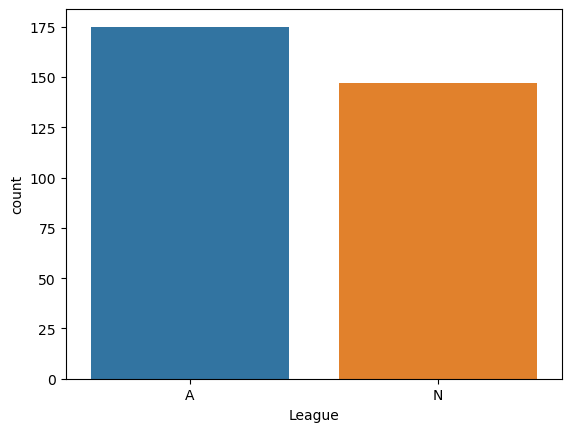

******************************

   Division      Ratio
W       165  51.242236
E       157  48.757764


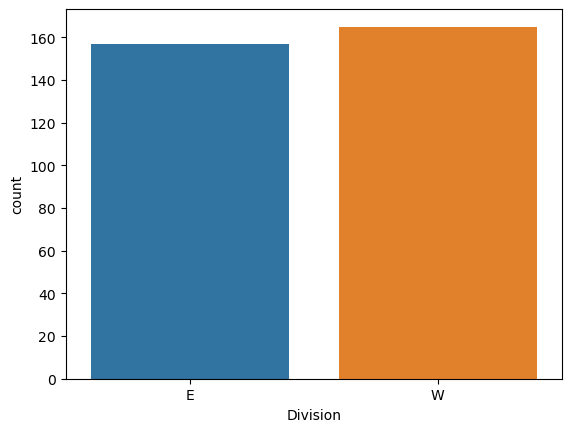

******************************

   NewLeague      Ratio
A        176  54.658385
N        146  45.341615


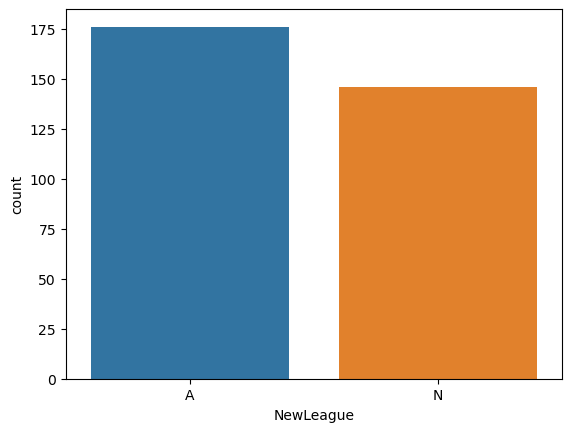

******************************



In [11]:
for col in cat_cols:
    cat_summary(df,col,plot=True)

***Let's analyze the target variable***

In [12]:
def target_summary_with_cat(dataframe,target,categorical_col):
    print(pd.DataFrame({"TARGET_MEAN":dataframe.groupby(categorical_col)[target].mean()}),end = "\n\n\n")

In [13]:
for col in cat_cols:
    target_summary_with_cat(df,"Salary",col)

        TARGET_MEAN
League             
A        541.999547
N        529.117500


          TARGET_MEAN
Division             
E          624.271364
W          450.876873


           TARGET_MEAN
NewLeague             
A           537.113028
N           534.553852




***Correlation Analysis***

Correlation analysis is a statistical method that provides information about the relationship between variables, 
including its direction and severity.(Korelasyon analizi;değişkenler arasındaki ilişki,bu ilişkinin yönü ve şiddeti ile 
ilgili bilgi sağlayan istatistiksel bir yöntemdir.)

In [14]:
corr = df[num_cols].corr()

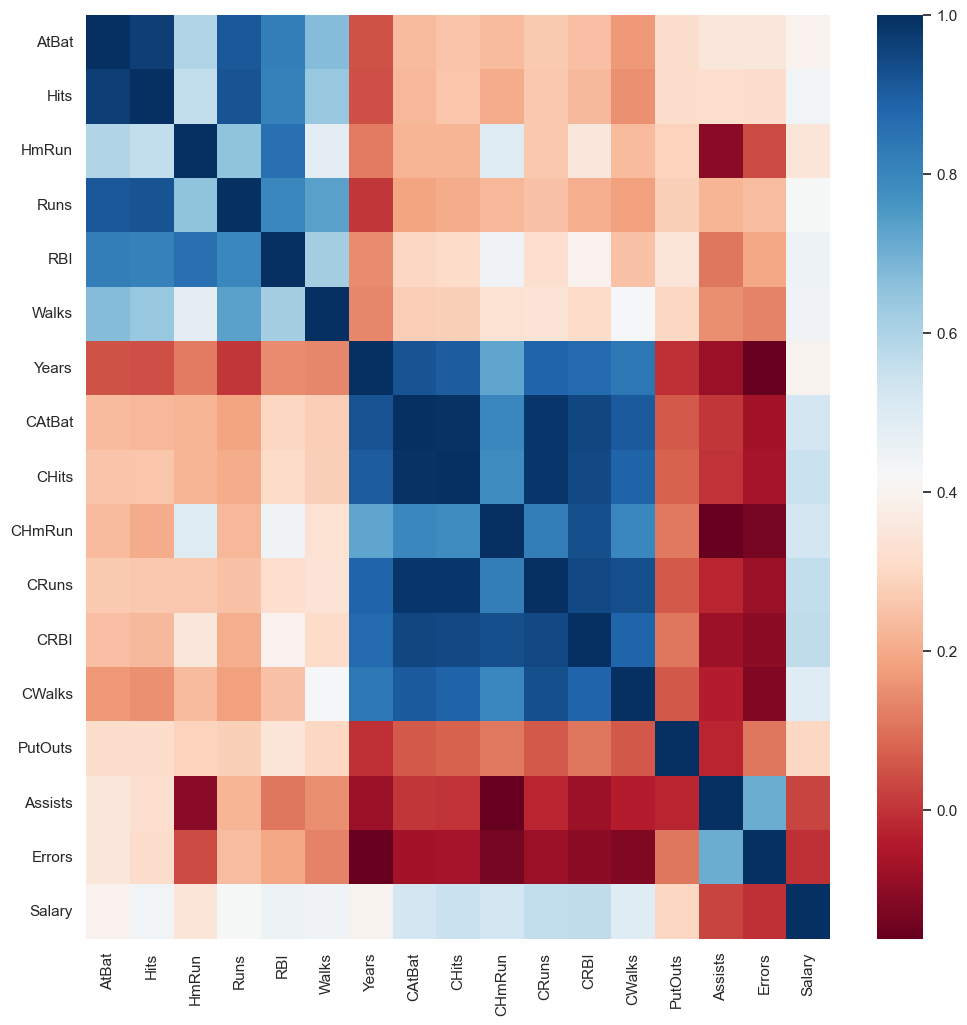

In [15]:
sns.set(rc = {"figure.figsize":(12,12)})
sns.heatmap(corr,cmap ="RdBu")
plt.show()

***Data Preprocessing***

1.Missing Values(Eksik Değerler)

In [16]:
def missing_values(df): 
    missing_value = df.isnull().sum()
    missing_value_rate = 100 * df.isnull().sum()/len(df)
    missing_value_table = pd.concat([missing_value, missing_value_rate], axis=1)
    missing_value_latest_table = missing_value_table.rename(
    columns = {0 : 'Missing Values', 1 : '% Value'})
    return missing_value_latest_table

In [17]:
missing_values(df)

,Missing Values,% Value
AtBat,0,0.000000
Hits,0,0.000000
HmRun,0,0.000000
Runs,0,0.000000
RBI,0,0.000000
Walks,0,0.000000
Years,0,0.000000
CAtBat,0,0.000000
CHits,0,0.000000
CHmRun,0,0.000000


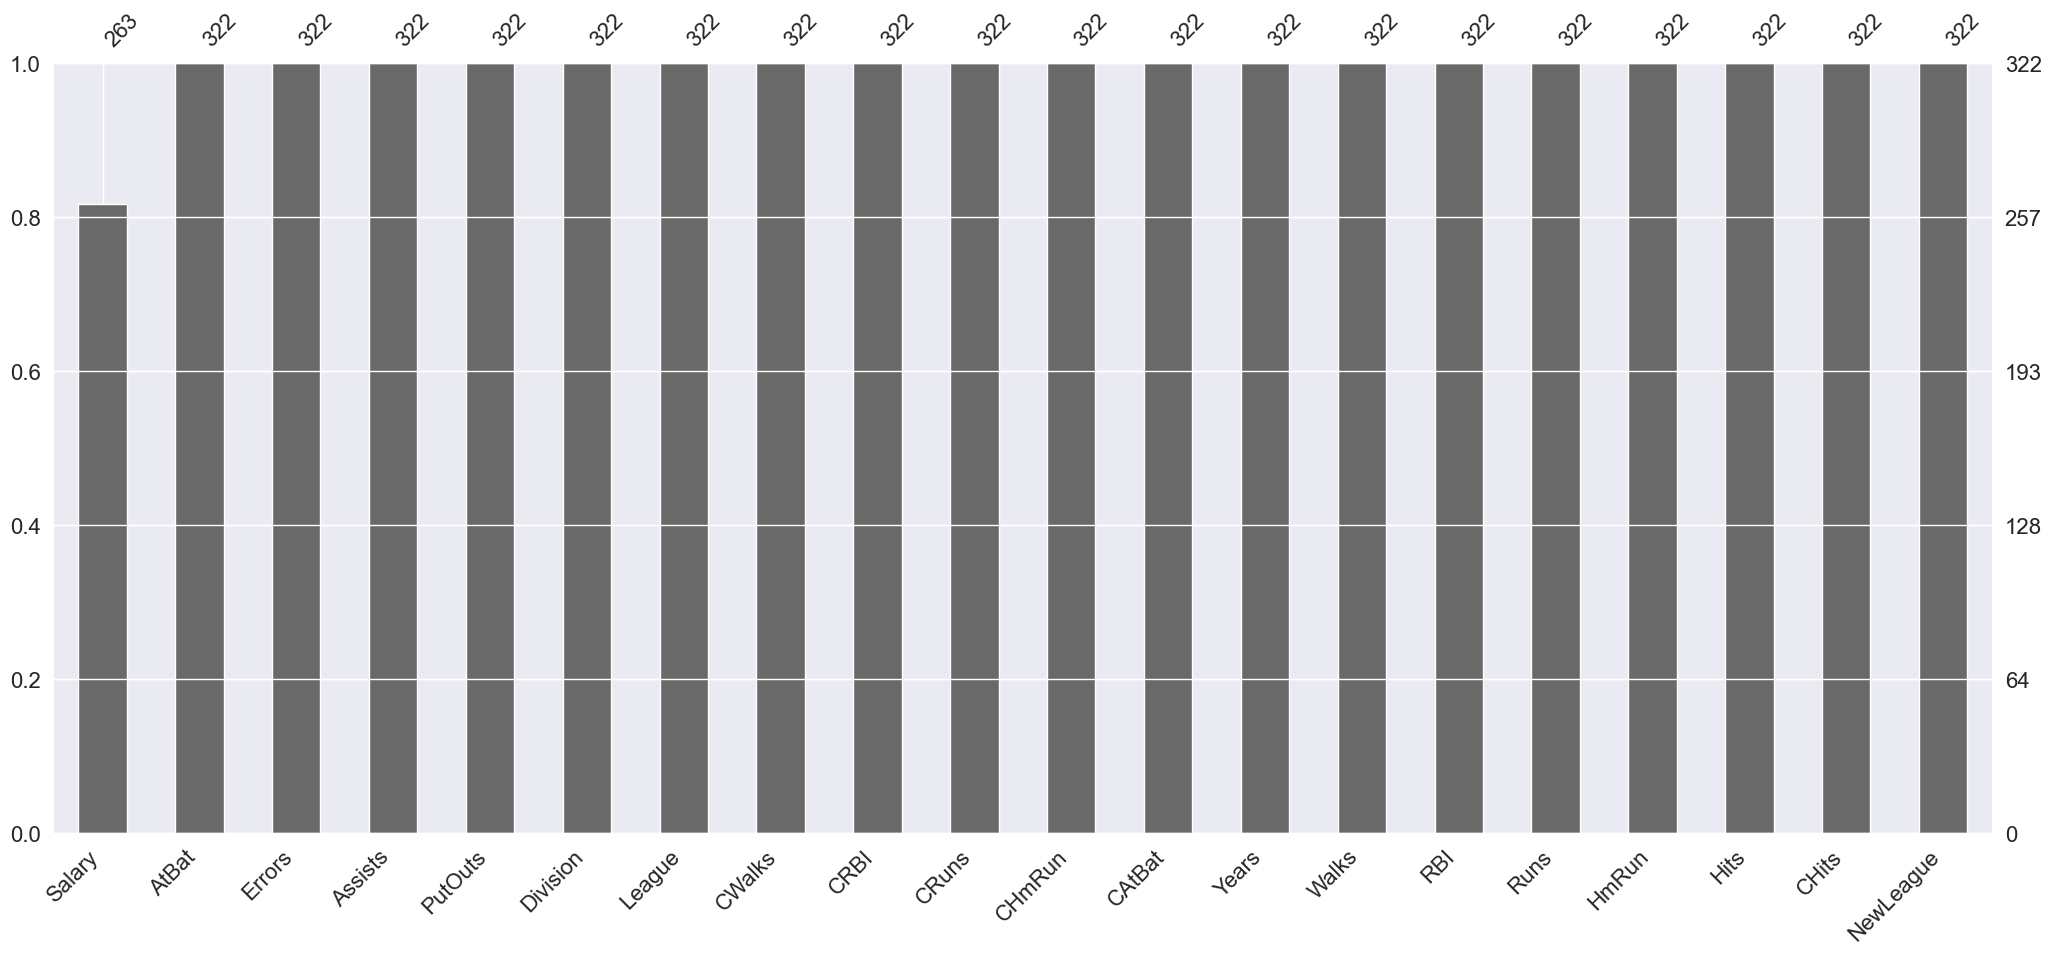

In [18]:
import missingno as msno
msno.bar(df,sort="ascending");

In [19]:
df['Salary'] = df['Salary'].fillna(df['Salary'].mean())

In [20]:
missing_values(df)

,Missing Values,% Value
AtBat,0,0.0
Hits,0,0.0
HmRun,0,0.0
Runs,0,0.0
RBI,0,0.0
Walks,0,0.0
Years,0,0.0
CAtBat,0,0.0
CHits,0,0.0
CHmRun,0,0.0


2.Outliers(Aykırı Değerler)

In [21]:
def IQR(dataframe, col_name, q1=0.25, q3=0.75):
    quartile1 = dataframe[col_name].quantile(q1)
    quartile3 = dataframe[col_name].quantile(q3)
    interquantile_range = quartile3 - quartile1
    up_limit = quartile3 + 1.5 * interquantile_range
    low_limit = quartile1 - 1.5 * interquantile_range
    return low_limit, up_limit

In [22]:
def replace_with_thresholds(dataframe, variable):
    low_limit, up_limit = IQR(dataframe, variable)
    dataframe.loc[(dataframe[variable] < low_limit), variable] = low_limit
    dataframe.loc[(dataframe[variable] > up_limit), variable] = up_limit

In [23]:
for col in num_cols:
    replace_with_thresholds(df, col)

In [24]:
df.shape

(322, 20)

3.Feature Extraction(Özellik Çıkarımı)

In [25]:
new_num_cols=[col for col in num_cols if col!="Salary"]
df[new_num_cols]=df[new_num_cols]+0.0000000001
df['NEW_Hits'] = df['Hits'] / df['CHits'] + df['Hits']
df['NEW_RBI'] = df['RBI'] / df['CRBI']
df['NEW_Walks'] = df['Walks'] / df['CWalks']
df['NEW_PutOuts'] = df['PutOuts'] * df['Years']
df["Hits_Success"] = (df["Hits"] / df["AtBat"]) * 100
df["NEW_CRBI*CATBAT"] = df['CRBI'] * df['CAtBat']
df["NEW_RBI"] = df["RBI"] / df["CRBI"]
df["NEW_Chits"] = df["CHits"] / df["Years"]
df["NEW_CHmRun"] = df["CHmRun"] * df["Years"]
df["NEW_CRuns"] = df["CRuns"] / df["Years"]
df["NEW_Chits"] = df["CHits"] * df["Years"]
df["NEW_RW"] = df["RBI"] * df["Walks"]
df["NEW_RBWALK"] = df["RBI"] / df["Walks"]
df["NEW_CH_CB"] = df["CHits"] / df["CAtBat"]
df["NEW_CHm_CAT"] = df["CHmRun"] / df["CAtBat"]

4.Encoding:One Hot Encoding(Değişken Dönüşümü)

In [26]:
df = pd.get_dummies(df, columns=cat_cols, drop_first=True)
df

,AtBat,Hits,HmRun,Runs,RBI,Walks,Years,CAtBat,CHits,CHmRun,...,NEW_Chits,NEW_CHmRun,NEW_CRuns,NEW_RW,NEW_RBWALK,NEW_CH_CB,NEW_CHm_CAT,League_N,Division_W,NewLeague_N
0,293.0,66.0,1.0,30.0,29.0,14.0,1.0,293.0,66.0,1.0,...,66.0,1.0,30.000000,406.0,2.071429,0.225256,0.003413,0,0,0
1,315.0,81.0,7.0,24.0,38.0,39.0,14.0,3449.0,835.0,69.0,...,11690.0,966.0,22.928571,1482.0,0.974359,0.242099,0.020006,1,1,1
2,479.0,130.0,18.0,66.0,72.0,76.0,3.0,1624.0,457.0,63.0,...,1371.0,189.0,74.666667,5472.0,0.947368,0.281404,0.038793,0,1,0
3,496.0,141.0,20.0,65.0,78.0,37.0,11.0,5628.0,1575.0,204.0,...,17325.0,2244.0,75.272727,2886.0,2.108108,0.279851,0.036247,1,0,1
4,321.0,87.0,10.0,39.0,42.0,30.0,2.0,396.0,101.0,12.0,...,202.0,24.0,24.000000,1260.0,1.400000,0.255051,0.030303,1,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
317,497.0,127.0,7.0,65.0,48.0,37.0,5.0,2703.0,806.0,32.0,...,4030.0,160.0,75.800000,1776.0,1.297297,0.298187,0.011839,1,0,1
318,492.0,136.0,5.0,76.0,50.0,94.0,12.0,5511.0,1511.0,39.0,...,18132.0,468.0,74.750000,4700.0,0.531915,0.274179,0.007077,0,0,0
319,475.0,126.0,3.0,61.0,43.0,52.0,6.0,1700.0,433.0,7.0,...,2598.0,42.0,36.166667,2236.0,0.826923,0.254706,0.004118,0,1,0
320,573.0,144.0,9.0,85.0,60.0,78.0,8.0,3198.0,857.0,97.0,...,6856.0,776.0,58.750000,4680.0,0.769231,0.267980,0.030331,0,0,0


5.Feature Scaling(Özellik Ölçekleme)

In [27]:
cat_cols, num_cols, cat_but_car = grab_col_names(df)
num_cols = [col for col in num_cols if col not in ["Salary"]]
scaler = StandardScaler()
df[num_cols] = scaler.fit_transform(df[num_cols])
df.head()

Observations: 322
Variables: 33
cat_cols: 3
num_cols: 30
cat_but_car: 0
num_but_cat: 3


,AtBat,Hits,HmRun,Runs,RBI,Walks,Years,CAtBat,CHits,CHmRun,...,NEW_Chits,NEW_CHmRun,NEW_CRuns,NEW_RW,NEW_RBWALK,NEW_CH_CB,NEW_CHm_CAT,League_N,Division_W,NewLeague_N
0,-0.574071,-0.755130,-1.129528,-0.805218,-0.728445,-1.147050,-1.317944,-1.043259,-1.035269,-0.955960,...,-0.740606,-0.682255,-0.630697,-0.901323,0.828523,-1.414883,-1.362901,0,0,0
1,-0.430437,-0.431732,-0.434323,-1.036370,-0.383835,0.012751,1.345945,0.369158,0.203940,0.119170,...,0.343170,0.274821,-0.966944,-0.362861,-0.558126,-0.752377,-0.230218,1,1,1
2,0.640293,0.624699,0.840219,0.581693,0.918021,1.729256,-0.908115,-0.447592,-0.405190,0.024305,...,-0.618933,-0.495798,1.493212,1.633850,-0.592241,0.793629,1.052267,0,1,0
3,0.751283,0.861858,1.071954,0.543168,1.147761,-0.080033,0.731201,1.344334,1.396417,2.253619,...,0.868555,1.542326,1.522030,0.339741,0.874884,0.732536,0.878485,1,0,1
4,-0.391264,-0.302373,-0.086721,-0.458490,-0.230676,-0.404778,-1.113030,-0.997163,-0.978868,-0.782042,...,-0.727926,-0.659443,-0.915998,-0.473957,-0.020134,-0.242951,0.472706,1,0,1


***Modelling***

In [28]:
def compML(df,y,alg):
    # train-test ayrımı
    y = df["Salary"]
    X = df.drop(["Salary"], axis=1)   
    X_train,X_test,y_train,y_test = train_test_split(X,y,test_size = 0.25,random_state = 42)
    # modelleme
    if alg == CatBoostRegressor:
        model = CatBoostRegressor(verbose=False).fit(X_train,y_train)
    else: 
        model = alg().fit(X_train,y_train)
    y_pred = model.predict(X_test)
    RMSE = np.sqrt(mean_squared_error(y_test,y_pred))
    model_ismi = alg.__name__
    print(model_ismi,':Modeli Test Hatası:',RMSE)
    
models = [LGBMRegressor,XGBRegressor,Ridge,Lasso,ElasticNet,GradientBoostingRegressor,MLPRegressor,RandomForestRegressor,
          KNeighborsRegressor,SVR,LinearRegression,CatBoostRegressor,DecisionTreeRegressor]
for i in models:
    compML(df,"Salary",i)


LGBMRegressor :Modeli Test Hatası: 214.7801800703398
XGBRegressor :Modeli Test Hatası: 226.83065095189264
Ridge :Modeli Test Hatası: 229.36178939058112
Lasso :Modeli Test Hatası: 227.48181569723053
ElasticNet :Modeli Test Hatası: 253.5752660157999


D:\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 6.495e+03, tolerance: 2.799e+03
  model = cd_fast.enet_coordinate_descent(


GradientBoostingRegressor :Modeli Test Hatası: 207.42659591149055


D:\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


MLPRegressor :Modeli Test Hatası: 440.0588473823665
RandomForestRegressor :Modeli Test Hatası: 194.51809078025104
KNeighborsRegressor :Modeli Test Hatası: 235.45993490930294
SVR :Modeli Test Hatası: 344.3670489727879
LinearRegression :Modeli Test Hatası: 239.9922359226654
CatBoostRegressor :Modeli Test Hatası: 218.9097477833621
DecisionTreeRegressor :Modeli Test Hatası: 286.88882026750105


***Model Tuning and Feature Importance***

Random Forests Model Tuning

In [29]:
y = df["Salary"]
X = df.drop(["Salary"], axis=1)   
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size = 0.25,random_state = 42)

In [30]:
rf_model = RandomForestRegressor(random_state = 42).fit(X_train,y_train)

In [31]:
rf_params = {"max_depth":[5,8,10],
             "max_features":[2,5,10],
             "n_estimators":[50,100,150],
             "min_samples_split":[2,10,80]}

In [32]:
rf_cv_model=GridSearchCV(rf_model,rf_params,cv=10,n_jobs=-1,verbose=2).fit(X_train,y_train) 

Fitting 10 folds for each of 81 candidates, totalling 810 fits


In [33]:
rf_cv_model.best_params_

{'max_depth': 5,
 'max_features': 10,
 'min_samples_split': 10,
 'n_estimators': 150}

In [34]:
rf_model = RandomForestRegressor(random_state = 42,max_depth=5,max_features=10,min_samples_split=10,n_estimators=150)

In [35]:
rf_tuned = rf_model.fit(X_train,y_train)
y_pred = rf_tuned.predict(X_test)
np.sqrt(mean_squared_error(y_test,y_pred))

204.30843843433965

In [36]:
# Feature Importance Levels
rf_tuned.feature_importances_*100

array([ 3.67651355,  3.02999644,  1.27018625,  2.02725336,  3.23059042,
        2.09810711,  0.52033634,  5.80234624, 10.7809034 ,  1.34072348,
        7.37664688,  9.37183733,  3.85262079,  0.59973075,  0.80798572,
        0.32401105,  3.43131187,  4.56702847,  1.78053927,  1.12838234,
        1.22973552,  5.92127621,  8.05626185,  1.40051125,  4.71648996,
        7.0800186 ,  0.80788413,  2.30425217,  1.01511427,  0.07189553,
        0.34106625,  0.03844321])

In [37]:
Importance =pd.DataFrame({'Importance':rf_tuned.feature_importances_*100},index =X_train.columns)

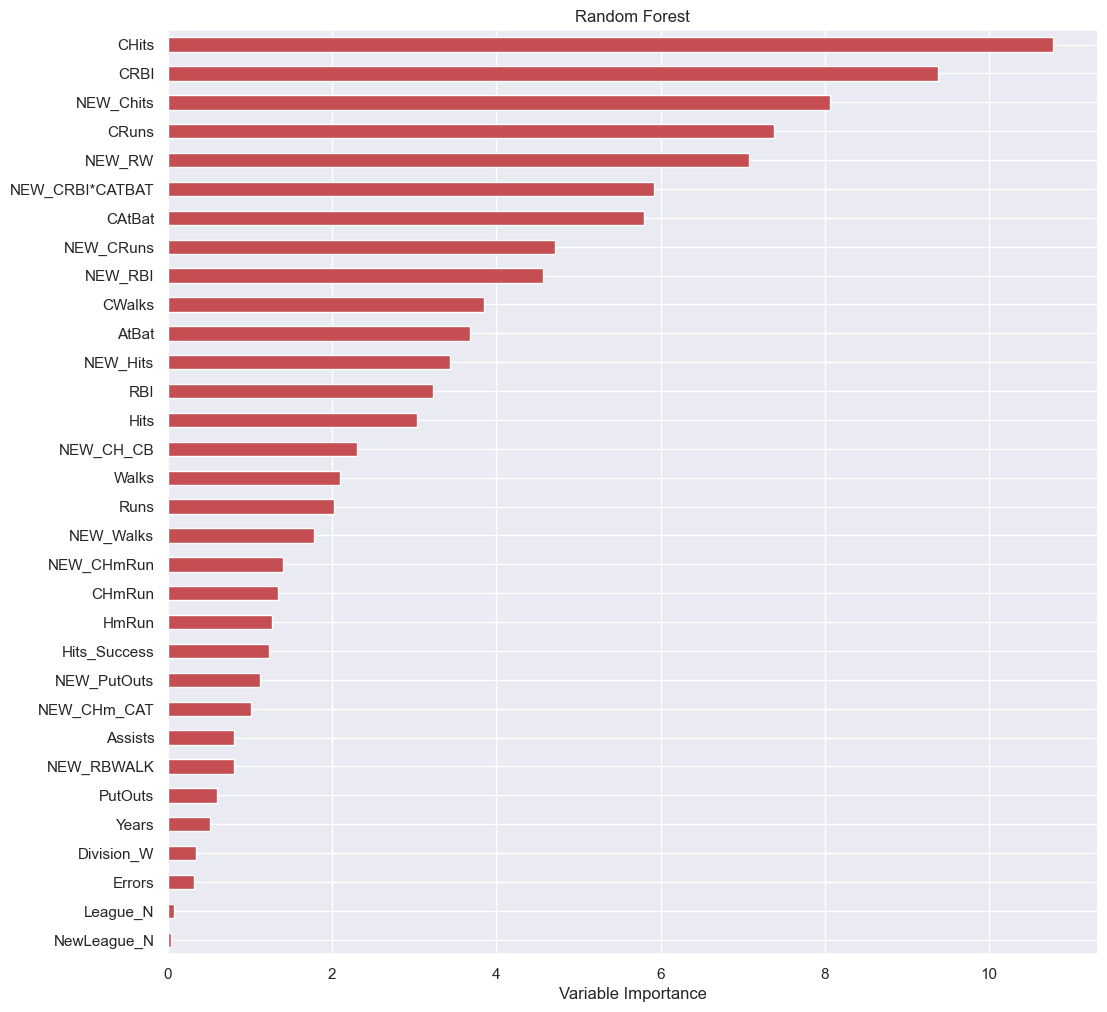

In [38]:
Importance.sort_values(by = 'Importance',axis=0,ascending=True).plot(kind = 'barh',color = 'r');
plt.xlabel('Variable Importance')
plt.title("Random Forest")
plt.gca().legend_=None

Gradient Boosting Machines(GBM) Model Tuning

In [39]:
y = df["Salary"]
X = df.drop(["Salary"], axis=1)   
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size = 0.25,random_state = 42)

In [40]:
gbm_params={'learning_rate':[0.001,0.1],
            'max_depth':[3,5],
            'n_estimators':[100,200],
            'subsample':[1,0.5],
            'loss':["ls","lad","quantile"]}

In [41]:
gbm_model=GradientBoostingRegressor().fit(X_train,y_train)

In [42]:
gbm_cv_model = GridSearchCV(gbm_model,gbm_params,cv=10,n_jobs=-1,verbose=2).fit(X_train,y_train) 

Fitting 10 folds for each of 48 candidates, totalling 480 fits


D:\Anaconda3\lib\site-packages\sklearn\ensemble\_gb.py:286: FutureWarning: The loss 'ls' was deprecated in v1.0 and will be removed in version 1.2. Use 'squared_error' which is equivalent.
  warnings.warn(


In [43]:
gbm_cv_model.best_params_

{'learning_rate': 0.1,
 'loss': 'ls',
 'max_depth': 3,
 'n_estimators': 100,
 'subsample': 1}

In [44]:
gbm_tuned = GradientBoostingRegressor(learning_rate = 0.1,loss = 'ls',max_depth = 3,n_estimators = 100,
                                      subsample= 1).fit(X_train,y_train)

D:\Anaconda3\lib\site-packages\sklearn\ensemble\_gb.py:286: FutureWarning: The loss 'ls' was deprecated in v1.0 and will be removed in version 1.2. Use 'squared_error' which is equivalent.
  warnings.warn(


In [45]:
y_pred = gbm_tuned.predict(X_test)
np.sqrt(mean_squared_error(y_test,y_pred))

204.46992267216496

In [46]:
# Feature Importance Levels
gbm_tuned.feature_importances_*100

array([ 5.38287   ,  0.65202812,  0.98889274,  2.06544682,  0.4661195 ,
        0.49605192,  1.00688487,  0.5338993 , 17.54673315,  1.33741098,
        4.91593855, 14.08014155,  1.17192395,  1.20154378,  1.63060547,
        0.17983193,  3.49035011,  4.26479309,  0.67074671,  2.2827159 ,
        1.06255742,  0.31586973,  7.3572012 ,  1.35949029,  6.8935355 ,
        8.7975005 ,  1.37881643,  4.78185478,  2.240038  ,  0.33440093,
        0.83433044,  0.27947634])

In [47]:
Importance =pd.DataFrame({'Importance':gbm_tuned.feature_importances_*100},index =X_train.columns)

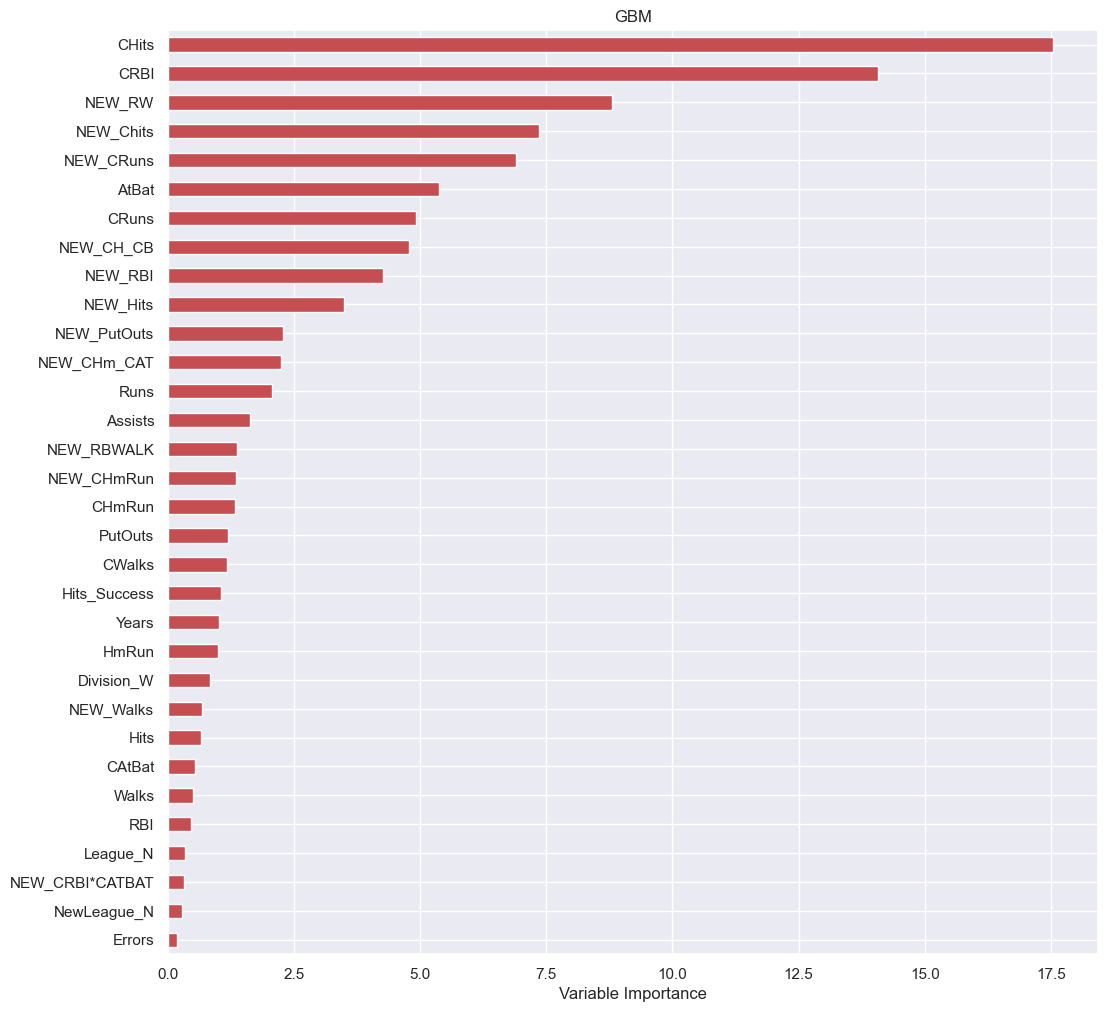

In [48]:
Importance.sort_values(by = 'Importance',axis=0,ascending=True).plot(kind = 'barh',color = 'r');
plt.xlabel('Variable Importance')
plt.title("GBM")
plt.gca().legend_=None

CatBoost Model Tuning

In [49]:
y = df["Salary"]
X = df.drop(["Salary"], axis=1)   
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size = 0.25,random_state = 42)

In [50]:
catb_model = CatBoostRegressor(verbose=False).fit(X_train,y_train)

In [51]:
catb_params= {'iterations':[200,500,100],
              'learning_rate':[0.01,0.1],
              'depth':[3,6,8]}

In [52]:
catb_cv_model = GridSearchCV(catb_model,catb_params,cv=5,n_jobs=-1,verbose=2).fit(X_train,y_train)

Fitting 5 folds for each of 18 candidates, totalling 90 fits


In [53]:
catb_cv_model.best_params_

{'depth': 3, 'iterations': 500, 'learning_rate': 0.01}

In [54]:
catb_tuned = CatBoostRegressor(depth=3,iterations=500,learning_rate=0.01,verbose=False).fit(X_train,y_train)

In [55]:
y_pred = catb_tuned.predict(X_test)
np.sqrt(mean_squared_error(y_test,y_pred))

212.48822467842382

In [56]:
# Feature Importance Levels
catb_tuned.feature_importances_*100

array([348.08701126, 502.30665662, 144.52238987, 172.73993798,
       130.66191588, 254.63202406, 108.55870512, 349.35083171,
       439.00782944, 304.07327301, 830.12317698, 797.12556616,
       444.43418595,  75.90646136,  25.71033981,  25.49951388,
       278.48735263, 593.77795187, 336.0210544 , 213.67622903,
        55.25824755, 567.39740593, 998.18862482, 115.81331694,
       494.89947959, 901.47962   ,  17.76260573, 317.0591607 ,
        62.05768115,  12.43540887,  67.23160107,  15.71444064])

In [57]:
Importance =pd.DataFrame({'Importance':catb_tuned.feature_importances_*100},index =X_train.columns)

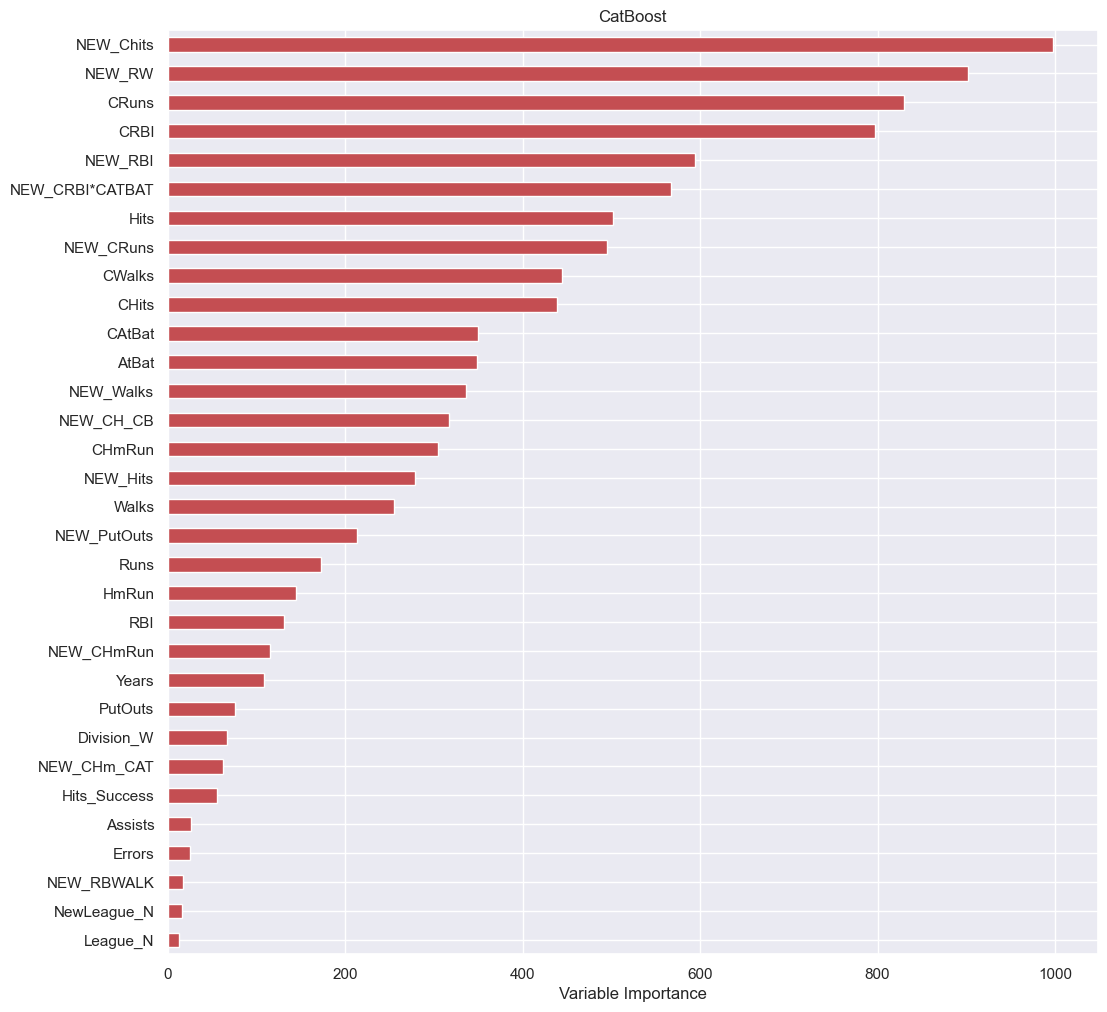

In [58]:
Importance.sort_values(by = 'Importance',axis=0,ascending=True).plot(kind = 'barh',color = 'r');
plt.xlabel('Variable Importance')
plt.title("CatBoost")
plt.gca().legend_=None

Light GBM Model Tuning

In [59]:
y = df["Salary"]
X = df.drop(["Salary"], axis=1)   
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size = 0.25,random_state = 42)

In [60]:
lgbm_model = LGBMRegressor().fit(X_train,y_train)

In [61]:
lgbm_params = {'learning_rate':[0.01,0.1,0.5,1],
               'n_estimators':[20,40,100,200,500,1000],
               'max_depth':[1,2,3,4,5,6,7,8,9,10]}

In [62]:
lgbm_cv_model = GridSearchCV(lgbm_model,lgbm_params,cv=10,n_jobs=-1,verbose =2).fit(X_train,y_train)

Fitting 10 folds for each of 240 candidates, totalling 2400 fits


In [63]:
lgbm_cv_model.best_params_

{'learning_rate': 0.1, 'max_depth': 2, 'n_estimators': 40}

In [64]:
lgbm_tuned = LGBMRegressor(learning_rate = 0.1,max_depth=2,n_estimators=40).fit(X_train,y_train)

In [65]:
y_pred = lgbm_tuned.predict(X_test)
np.sqrt(mean_squared_error(y_test,y_pred))

212.04815124473865

In [66]:
# Feature Importance Levels
lgbm_tuned.feature_importances_*100

array([ 300,  100,  100,  200,  400,  300,  300,  200,  200,  600,  300,
        400,    0,  400,    0,  100,  300, 1400,  200,  600,  100,  100,
        100,    0,  700, 1000,  100, 1100,  600,  200,    0,    0])

In [67]:
Importance =pd.DataFrame({'Importance':lgbm_tuned.feature_importances_*100},index =X_train.columns)

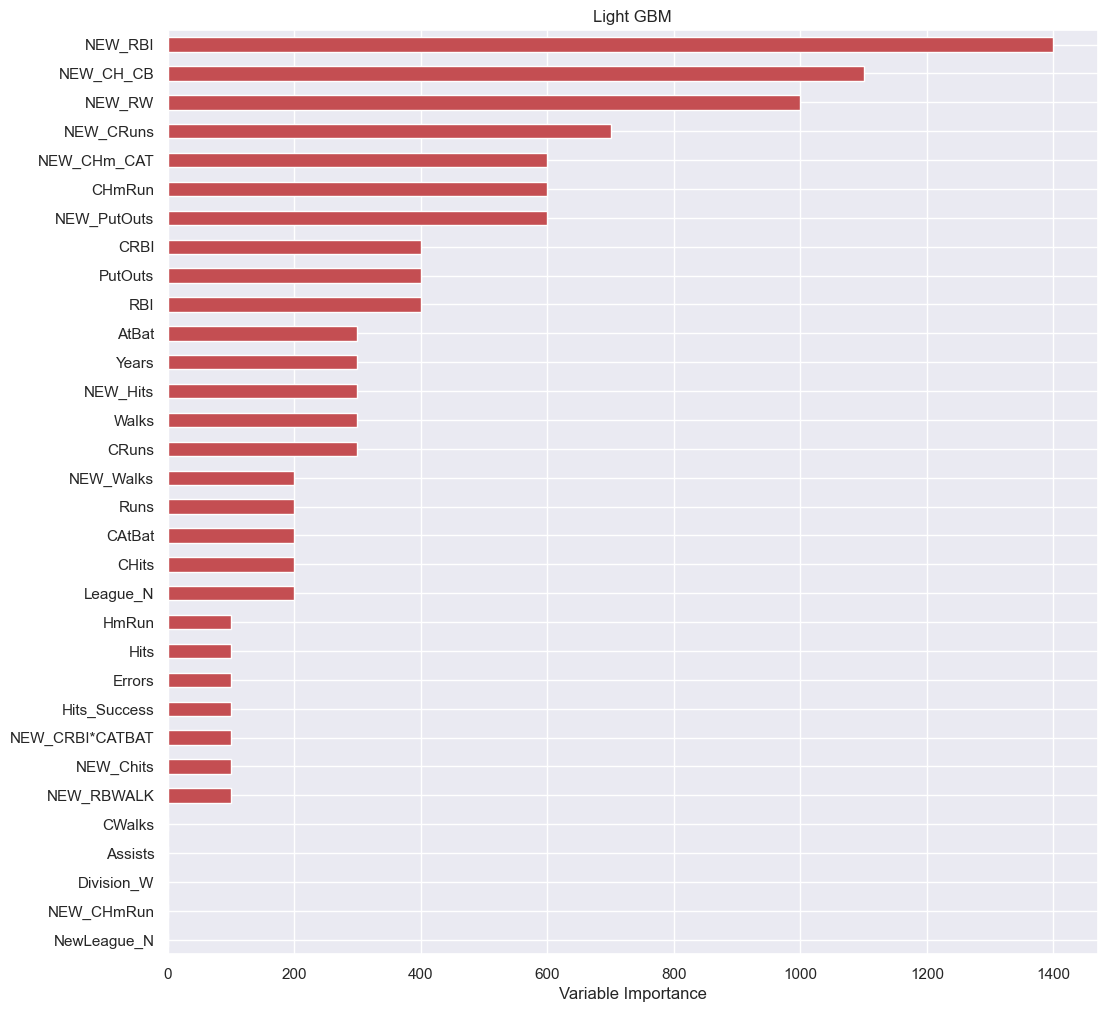

In [68]:
Importance.sort_values(by = 'Importance',axis=0,ascending=True).plot(kind = 'barh',color = 'r');
plt.xlabel('Variable Importance')
plt.title("Light GBM")
plt.gca().legend_=None

XGBoost Model Tuning and Feature Importance

In [69]:
y = df["Salary"]
X = df.drop(["Salary"], axis=1)   
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size = 0.25,random_state = 42)

In [70]:
xgb_model = XGBRegressor().fit(X_train,y_train)

In [71]:
xgb_params = {'learning_rate':[0.1,0.01,0.5],
              'max_depth':[2,3,4,5,8],
              'n_estimators':[100,200,500],
              'colsample_bytree':[0.4,0.7,1]}

In [72]:
xgb_cv_model = GridSearchCV(xgb_model,xgb_params,cv=10,n_jobs=-1,verbose=2).fit(X_train,y_train)

Fitting 10 folds for each of 135 candidates, totalling 1350 fits


In [73]:
xgb_cv_model.best_params_

{'colsample_bytree': 1,
 'learning_rate': 0.01,
 'max_depth': 2,
 'n_estimators': 500}

In [74]:
xgb_tuned = XGBRegressor(colsample_bytree=1,learning_rate=0.01,max_depth=2,n_estimators=500).fit(X_train,y_train)

In [75]:
y_pred = xgb_tuned.predict(X_test)
np.sqrt(mean_squared_error(y_test,y_pred))

212.21765037134108

In [76]:
# Feature Importance Levels
xgb_tuned.feature_importances_*100

array([ 3.8838506 ,  2.0146053 ,  1.0507677 ,  2.1281166 ,  0.95061314,
        1.0736455 ,  1.027067  ,  3.274539  , 13.571191  ,  2.7466345 ,
       16.443151  , 19.60846   ,  0.9424178 ,  0.        ,  0.69705355,
        0.        ,  2.4886305 ,  2.8370192 ,  0.        ,  1.2047514 ,
        1.1438177 ,  1.6398437 ,  5.2721405 ,  1.4701786 ,  4.0986767 ,
        5.5070524 ,  1.0452652 ,  1.4757849 ,  0.8742542 ,  0.        ,
        1.5304747 ,  0.        ], dtype=float32)

In [77]:
Importance =pd.DataFrame({'Importance':xgb_tuned.feature_importances_*100},index =X_train.columns)

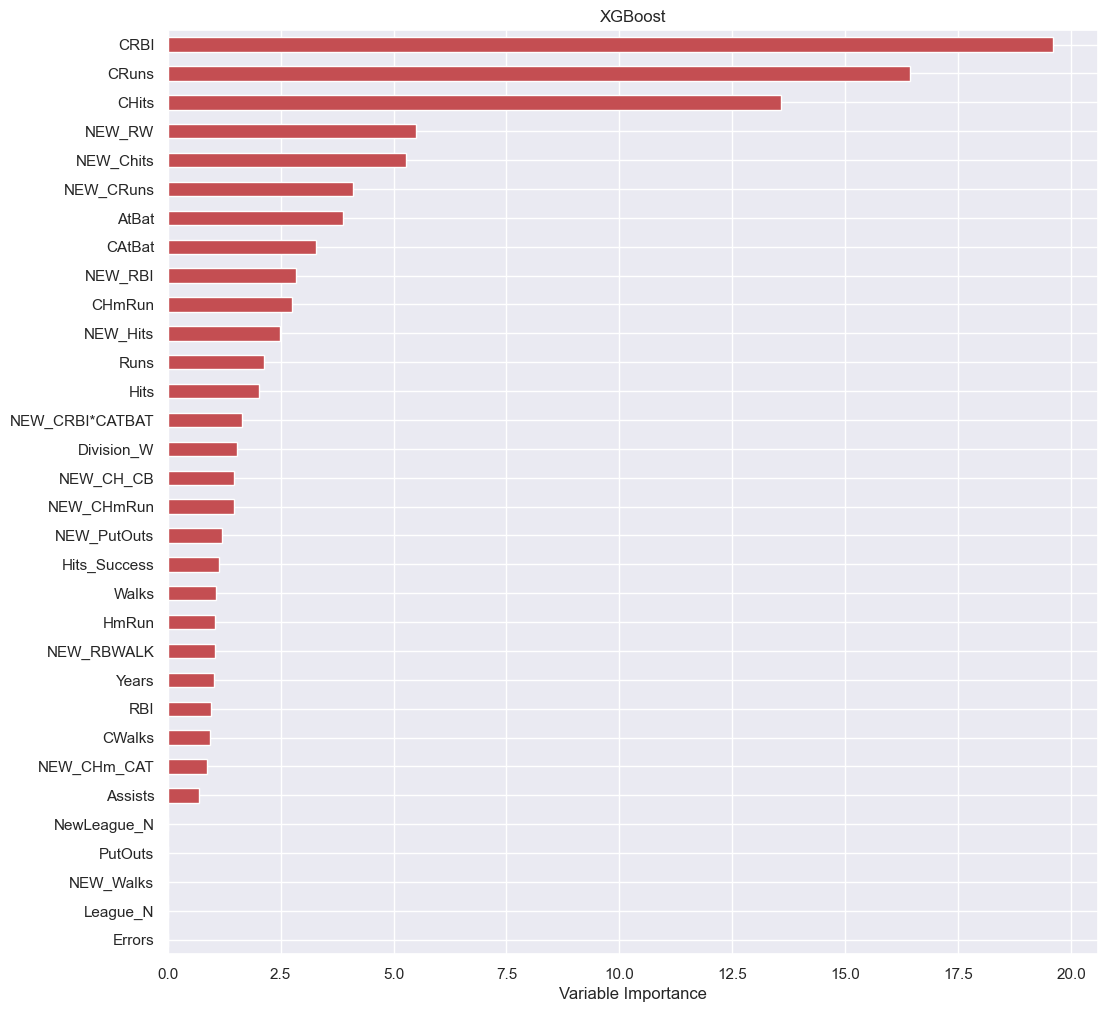

In [78]:
Importance.sort_values(by = 'Importance',axis=0,ascending=True).plot(kind = 'barh',color = 'r');
plt.xlabel('Variable Importance')
plt.title("XGBoost")
plt.gca().legend_=None

***Outcome:***

Random Forest is the regression model with the lowest RMSE value.